In [65]:
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [46]:
commodity_df = pd.read_excel('materialXrate.xlsx')

In [47]:
Cu_df = commodity_df[commodity_df['Symbol'] == 'Copper'][['Dates', 'Price']]
Cu_df.set_index('Dates', inplace=True)
Cu_df

,Price
Dates,
2019-01-31,2.68
2019-02-28,2.86
2019-03-31,2.90
2019-04-30,2.92
2019-05-31,2.74
...,...
2024-11-30,4.17
2024-12-31,4.11
2025-01-31,4.25


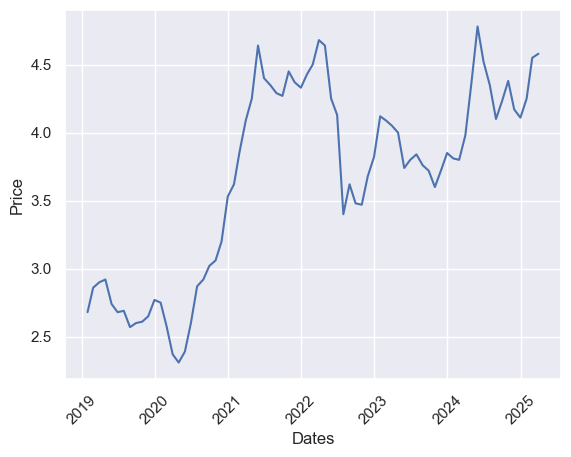

In [49]:
sns.set()
plt.ylabel('Price')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.plot(Cu_df.index, Cu_df['Price'])

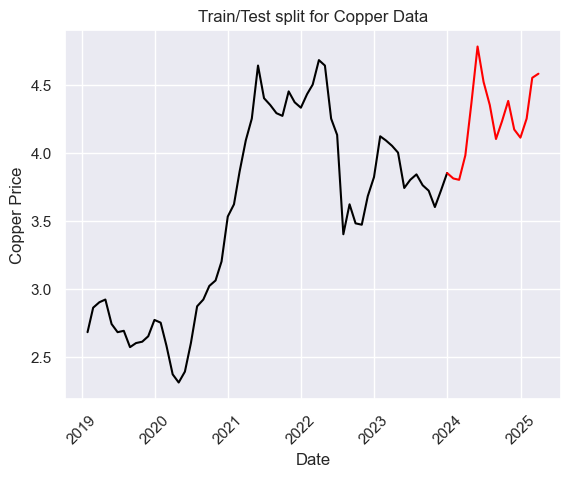

In [57]:
cu_train = Cu_df[Cu_df.index < pd.to_datetime("2024-01-01", format='%Y-%m-%d')]
cu_test = Cu_df[Cu_df.index > pd.to_datetime("2023-12-30", format='%Y-%m-%d')]

plt.plot(cu_train, color = "black")
plt.plot(cu_test, color = "red")
plt.ylabel('Copper Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Copper Data")
plt.show()

## Autoregressive Moving Average (ARMA) Model 

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [56]:
y = cu_train['Price']
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.
ARMAmodel = SARIMAX(y, order = (1, 0, 0))

ARMAmodel = ARMAmodel.fit()

c:\Users\zbrv6c\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\zbrv6c\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\zbrv6c\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [67]:
y_pred = ARMAmodel.get_forecast(len(cu_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = cu_test.index
y_pred_out_arma = y_pred_df["Predictions"] 

In [68]:
arma_rmse = np.sqrt(mean_squared_error(cu_test["Price"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  0.5277341247011511


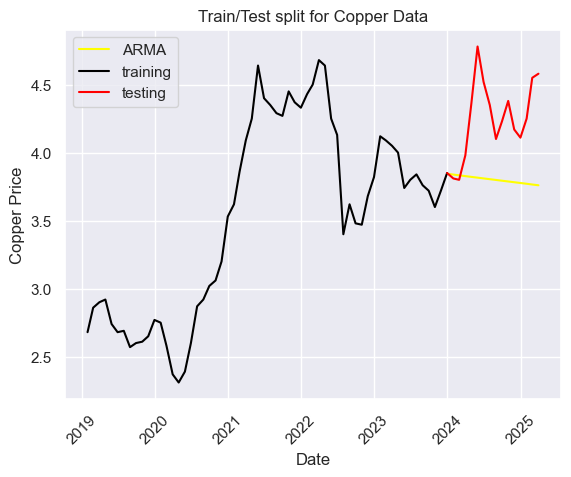

In [69]:
plt.plot(y_pred_out_arma, color='yellow', label = 'ARMA')
plt.plot(cu_train, color = "black", label = 'training')
plt.plot(cu_test, color = "red", label = 'testing')
plt.ylabel('Copper Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Copper Data")
plt.legend()

## ARIMA

### tune hyper paramenters

In [80]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))


In [81]:
import warnings
warnings.filterwarnings("ignore")

In [82]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(cu_train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.246
ARIMA(0, 0, 1) MSE=0.125
ARIMA(0, 0, 2) MSE=0.077
ARIMA(0, 1, 0) MSE=0.050
ARIMA(0, 1, 1) MSE=0.056
ARIMA(0, 1, 2) MSE=0.049
ARIMA(0, 2, 0) MSE=0.099
ARIMA(0, 2, 1) MSE=0.070
ARIMA(0, 2, 2) MSE=0.078
ARIMA(1, 0, 0) MSE=0.049
ARIMA(1, 0, 1) MSE=0.054
ARIMA(1, 0, 2) MSE=0.046
ARIMA(1, 1, 0) MSE=0.058
ARIMA(1, 1, 1) MSE=0.058
ARIMA(1, 1, 2) MSE=0.067
ARIMA(1, 2, 0) MSE=0.069
ARIMA(1, 2, 1) MSE=0.077
ARIMA(1, 2, 2) MSE=0.077
ARIMA(2, 0, 0) MSE=0.058
ARIMA(2, 0, 1) MSE=0.053
ARIMA(2, 0, 2) MSE=0.049
ARIMA(2, 1, 0) MSE=0.056
ARIMA(2, 1, 1) MSE=0.058
ARIMA(2, 1, 2) MSE=0.072
ARIMA(2, 2, 0) MSE=0.069
ARIMA(2, 2, 1) MSE=0.071
ARIMA(2, 2, 2) MSE=0.087
ARIMA(4, 0, 0) MSE=0.056
ARIMA(4, 0, 1) MSE=0.063
ARIMA(4, 0, 2) MSE=0.045
ARIMA(4, 1, 0) MSE=0.050
ARIMA(4, 1, 1) MSE=0.052
ARIMA(4, 1, 2) MSE=0.056
ARIMA(4, 2, 0) MSE=0.064
ARIMA(4, 2, 1) MSE=0.068
ARIMA(4, 2, 2) MSE=0.072
ARIMA(6, 0, 0) MSE=0.055
ARIMA(6, 0, 1) MSE=0.058
ARIMA(6, 0, 2) MSE=0.057
ARIMA(6, 1, 0) MSE=0.058


In [83]:
ARIMAmodel = ARIMA(y, order = (4, 0, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(cu_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = cu_test.index
y_pred_out_arima = y_pred_df["Predictions"] 

arma_rmse = np.sqrt(mean_squared_error(cu_test["Price"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  0.5994322077923803


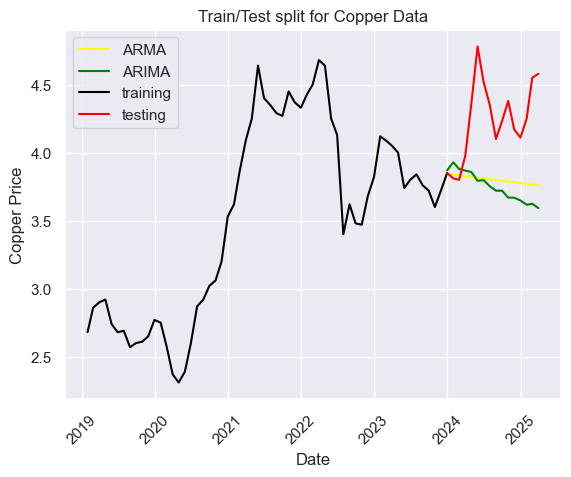

In [84]:
plt.plot(y_pred_out_arma, color='yellow', label = 'ARMA')
plt.plot(y_pred_out_arima, color='green', label = 'ARIMA')
plt.plot(cu_train, color = "black", label = 'training')
plt.plot(cu_test, color = "red", label = 'testing')
plt.ylabel('Copper Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Copper Data")
plt.legend()